# **1D Convolutional Neural Network (Conv1D) for Text Classification**  

In this notebook, we will explore how to build and train a **1D Convolutional Neural Network (Conv1D)** for text classification. Unlike Recurrent Neural Networks (RNNs), which process sequences step by step, Conv1D layers **capture local patterns** in text by applying filters over word embeddings, making them efficient for text classification tasks.  

**Conv1D** models are particularly useful for **capturing n-gram features**, such as phrases or local word dependencies, without the sequential recurrence constraints of RNNs. They are **computationally efficient** and have been successfully applied to tasks like sentiment analysis, spam detection, and product categorization.  

### **Objective:**  
- **Build** a Conv1D-based model for text classification.  
- **Train** and **evaluate** the model on a labeled dataset.  
- **Tune** hyperparameters to optimize model performance.  
- **Save** the trained model for future use. 

Since the **text data preprocessing** (tokenization, padding, and encoding) has already been completed in the previous notebook, we will import the preprocessed data and proceed directly to model construction, training, evaluation, and saving.  

### **Steps:**  
1. **Import Required Libraries and Setup**: Load the necessary libraries and set up project paths and configurations.  
2. **Import Preprocessed Data**: Load the tokenized and padded text data from the previous notebook.  
3. **Model Construction**: Define an initial **Conv1D-based architecture** as a baseline model.  
4. **Training the Model**: Train the model using the prepared dataset.  
5. **Evaluation**: Perform a **customized performance analysis** to assess the model's effectiveness on test data.  
6. **Hyperparameter Tuning**: Given computational constraints, we focus on optimizing only the most relevant parameters.  
7. **Save Models**: Save both the **initial trained Conv1D model** and the **best optimized model** for future use.

Conv1D-based architectures are a powerful alternative to RNNs, providing **faster training times** and **better parallelization** while effectively capturing local patterns in text sequences.  


## 1. Import Required Libraries 

In [10]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import sys
import os
import json
import pandas as pd
import numpy as np
import pickle


# Deep Learning (TensorFlow/Keras)
import tensorflow as tf
from tensorflow.keras import Sequential, layers, backend as K
from tensorflow.keras.layers import Embedding, Dense, GlobalMaxPooling1D, GlobalAveragePooling1D, RNN, Conv1D, Dropout, SpatialDropout1D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping


# Machine Learning & Model Evaluation
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from scikeras.wrappers import KerasClassifier



import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  

from pathlib import Path
import importlib
import itertools
from datetime import datetime



### Setting Up Project Paths and Configurations

In [2]:
# Get the current notebook directory
CURRENT_DIR = Path(os.getcwd()).resolve()

# Automatically find the project root (go up 2 level)
PROJECT_ROOT = CURRENT_DIR.parents[2]

# Add project root to sys.path
sys.path.append(str(PROJECT_ROOT))

# Function to get relative paths from project root
def get_relative_path(absolute_path):
    return str(Path(absolute_path).relative_to(PROJECT_ROOT))

# Print project root directory
print(f"Project Root Directory: {PROJECT_ROOT.name}")  # Display only the root folder name

import config  # Now Python can find config.py
importlib.reload(config)  # Reload config to ensure any updates are applied

Project Root Directory: Data_Scientist_Rakuten_Project-main


<module 'config' from 'D:\\Data_Science\\Append_Data_Engineer_AWS_MLOPS\\Data_Scientist_Rakuten_Project-main\\config.py'>

## 2. Import Preprocessed Data

In this step, we will import the preprocessed data that has already been tokenized and padded, with the original training dataset split into training and testing sets using `train_test_split`. The data we are importing includes:


- **X_train_split_tokenized**: The training data that has been tokenized, padded, and split from the original dataset.
- **X_test_split_tokenized**: The testing data that has been tokenized, padded, and split from the original dataset.
- **y_train_split**: The corresponding target labels for the training data, also split after applying `train_test_split`.
- **y_test_split**: The corresponding target labels for the testing data, after splitting.


In [3]:
# Define paths for datasets
xtrain_tokenized_path = Path(config.X_TRAIN_SPLIT_TOKENIZED_PATH)
xtest_tokenized_path = Path(config.X_TEST_SPLIT_TOKENIZED_PATH)
y_train_split_path = Path(config.Y_TRAIN_SPLIT_PATH)
y_test_split_path = Path(config.Y_TEST_SPLIT_PATH)


#  Load tokenizer
tokenizer_path = Path(config.TOKENIZER_PATH)
                    
# Function to get relative paths from project root
def get_relative_path(absolute_path: Path):
    """Returns the relative path from the project root."""
    return str(absolute_path.relative_to(config.BASE_DIR))

# Function to load a Pickle file safely
def load_pickle(file_path: Path, dataset_name: str):
    """Loads a pickle file with error handling and basic visualization."""
    if not file_path.exists():
        print(f"Error: `{dataset_name}` file not found at {file_path}")
        return None

    try:
        data = pd.read_pickle(file_path)
        print(f"Successfully loaded `{dataset_name}` | Shape: {data.shape}")
        
#         # Display first rows if dataset is not empty
#         if not data.empty:
#             display(data.head())

        return data
    except Exception as e:
        print(f"Error loading `{dataset_name}`: {e}")
        return None

        return None, None

def load_tokenizer(tokenizer_path: Path):
    """Loads the saved tokenizer and determines the correct vocabulary size."""
    if not tokenizer_path.exists():
        print(f"Error: `Tokenizer` not found at {tokenizer_path}")
        return None, None

    try:
        with open(tokenizer_path, 'rb') as handle:
            tokenizer = pickle.load(handle)

        # Check if num_words was set during training
        if tokenizer.num_words is not None:
            vocab_size = tokenizer.num_words  # Use the predefined vocabulary limit
        else:
            vocab_size = len(tokenizer.word_index) + 1  # Otherwise, use the full vocabulary

        # Print vocabulary details separately
        print(f"Tokenizer successfully loaded.")
        print(f"Vocabulary size used (vocab_size): {vocab_size}")
        print(f"Total words found in dataset: {len(tokenizer.word_index)}")

        return tokenizer, vocab_size
    except Exception as e:
        print(f"Error loading tokenizer: {e}")
        return None, None


    
# List of required files with their names
required_files = {
    "Tokenized Training Dataset": xtrain_tokenized_path,
    "Tokenized Testing Dataset": xtest_tokenized_path,
    "Training Labels": y_train_split_path,
    "Testing Labels": y_test_split_path,
    "Tokenizer": tokenizer_path  
}

# Check if files exist before loading
for name, path in required_files.items():
    if not path.exists():
        raise FileNotFoundError(f"Error: `{name}` file not found at {get_relative_path(path)}")

# Load datasets
X_train = load_pickle(xtrain_tokenized_path, "X_train_TokenizationSequencing.pkl")
X_test = load_pickle(xtest_tokenized_path, "X_test_TokenizationSequencing.pkl") # Submission dataset
y_train = load_pickle(y_train_split_path, "y_train_split.pkl")
y_test = load_pickle(y_test_split_path, "y_test_split.pkl")

# Load tokenizer
tokenizer, vocab_size = load_tokenizer(tokenizer_path)


Successfully loaded `X_train_TokenizationSequencing.pkl` | Shape: (67932, 500)
Successfully loaded `X_test_TokenizationSequencing.pkl` | Shape: (16984, 500)
Successfully loaded `y_train_split.pkl` | Shape: (67932,)
Successfully loaded `y_test_split.pkl` | Shape: (16984,)
Tokenizer successfully loaded.
Vocabulary size used (vocab_size): 20000
Total words found in dataset: 124636


## 3. 1D Convolutional Neural Network (Conv1D)

In this step, we construct a **Conv1D-based model** for text classification. Unlike RNNs, **Conv1D** applies filters to capture **local patterns** in word sequences, making it computationally efficient.  The architecture includes:   

- **Embedding Layer**: Transforms words into dense vector representations.  
- **Spatial Dropout**: Prevents overfitting by randomly deactivating word embeddings.  
- **Conv1D Layer**: Extracts **n-gram features** (local word dependencies) using **64 filters of size 2**.  
- **Global Max Pooling**: Reduces dimensionality by keeping only the most important features.  
- **Dense Output Layer**: Uses **softmax activation** to classify text into one of **27 categories**.  


In [31]:
# Define embedding dimension
embedding_dim = 100
# Compute the maximum sequence length in X_train
maxlen = max(len(seq) for seq in X_train)
print(f"Dynamic maxlen set to: {maxlen}")

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.SpatialDropout1D(0.2))
model.add(layers.Conv1D(64, 2, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(27, activation='softmax'))

         
model.summary()

Dynamic maxlen set to: 500
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 500, 100)          2000000   
                                                                 
 spatial_dropout1d_7 (Spatia  (None, 500, 100)         0         
 lDropout1D)                                                     
                                                                 
 conv1d_7 (Conv1D)           (None, 499, 64)           12864     
                                                                 
 global_max_pooling1d_7 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_13 (Dense)            (None, 27)                1755      
                                                                 
Total params: 2,014,619
Tra

## 4. Model Compilation, Training, and Evaluation

Before fine-tuning, we start with a **initial version** of our **1D Convolutional Neural Network (Conv1D)** for multi-class text classification. This helps establish a **baseline** while **keeping training time and computational cost manageable**.  

### Model Parameters 

**Number of Epochs**: `EPOCHS = 50`  
- The model is trained for **up to 50 epochs**, but **early stopping** is applied to stop training when validation loss stops improving.  
- This ensures **optimal stopping** without overfitting.  

**Early Stopping Parameter**:  
- **`monitor='val_loss'`** → Tracks validation loss to determine when to stop training.  
- **`patience=3`** → Training stops if validation loss does not improve for 3 consecutive epochs.  
- **`restore_best_weights=True`** → Restores the model weights from the epoch with the lowest validation loss.  
 
**Batch Size**: `BATCH_SIZE = 200`  
- A batch size of `200` balances **memory usage and convergence speed**.  
- Since **text sequences** can be long, using a **moderate batch size** prevents excessive **GPU/CPU memory consumption**.  
**Loss Function**: `sparse_categorical_crossentropy`  
- Best suited for **multi-class classification** with integer-labeled categories.  

**Optimizer**: `Adam (learning_rate=0.001)`  
- **Adam** (Adaptive Moment Estimation) is used because **it adjusts the learning rate automatically and helps the model learn faster and more efficiently**.
- We set `learning_rate=0.001`, which is the **default value**, but this can be fine-tuned later.  

**Metrics**: `accuracy` (excluding `weighted_f1` from `metrics`)  
- `accuracy` is a **quick and interpretable metric** for an initial evaluation.  
- If the **custom `weighted_f1` function does not work correctly**, we will compute the **Weighted F1-score manually** after evaluation to ensure accurate results.  






### 4.1 Custom Function for Weighted F1-Score

In [ ]:
# from sklearn.metrics import f1_score
# import tensorflow as tf
# from tensorflow.keras import backend as K

# # Custom function to calculate weighted F1 score
# def weighted_f1(y_true, y_pred):
#     # Convert predictions to binary format (0 or 1)
#     y_true = tf.argmax(y_true, axis=-1)
#     y_pred = tf.argmax(y_pred, axis=-1)
    
#     # Convert tensors to numpy arrays for calculation
#     y_true = y_true.numpy()  # This will work if eager execution is enabled
#     y_pred = y_pred.numpy()
    
#     # Compute the weighted F1 score using sklearn's f1_score
#     return f1_score(y_true, y_pred, average='weighted')


### 4.2 Model Compilation and Training

In [32]:
%%time

# Define Early Stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',    # Monitor validation loss
    patience=3,            # Stop training if no improvement after 3 epochs
    restore_best_weights=True  # Restore model weights from the best epoch
)



# Compile the model with Adam optimizer, sparse categorical crossentropy loss, and weighted F1-score as the metric
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']  
#     metrics=['accuracy', weighted_f1]  # Include weighted F1-score here - To Be Tested
)


# Define training parameters as variables
BATCH_SIZE = 200
EPOCHS = 50

# Train the model using the defined variables
history = model.fit(          
    X_train, 
    y_train.values, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    validation_data=(X_test, y_test.values),
    callbacks=[early_stopping]  # Include Early Stopping to prevent overfitting
)


Epoch 1/50
340/340 [==============================] - 4s 9ms/step - loss: 1.9728 - accuracy: 0.4798 - val_loss: 1.0894 - val_accuracy: 0.6981
Epoch 2/50
340/340 [==============================] - 3s 8ms/step - loss: 0.8508 - accuracy: 0.7645 - val_loss: 0.7832 - val_accuracy: 0.7750
Epoch 3/50
340/340 [==============================] - 3s 8ms/step - loss: 0.5799 - accuracy: 0.8330 - val_loss: 0.7019 - val_accuracy: 0.7930
Epoch 4/50
340/340 [==============================] - 3s 8ms/step - loss: 0.4248 - accuracy: 0.8796 - val_loss: 0.6762 - val_accuracy: 0.8001
Epoch 5/50
340/340 [==============================] - 3s 8ms/step - loss: 0.3194 - accuracy: 0.9113 - val_loss: 0.6862 - val_accuracy: 0.8020
Epoch 6/50
340/340 [==============================] - 3s 8ms/step - loss: 0.2429 - accuracy: 0.9341 - val_loss: 0.7066 - val_accuracy: 0.8035
Epoch 7/50
340/340 [==============================] - 3s 8ms/step - loss: 0.1885 - accuracy: 0.9502 - val_loss: 0.7355 - val_accuracy: 0.8030
Wall t

### 4.3 Learning Curve Analysis

#### 4.3.1 Display the Learning Curves

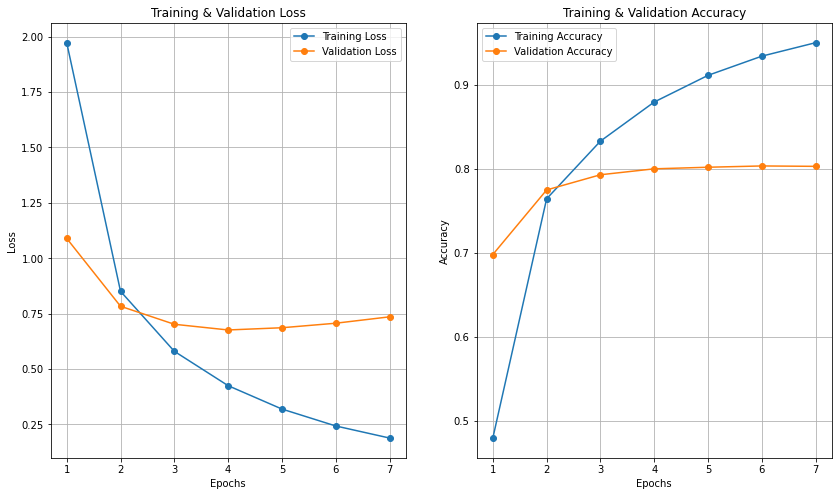

In [33]:
def plot_learning_curves(history):
    """
    Plots training & validation loss and accuracy over epochs.
    
    Args:
        history: Can be either:
            - A Keras `History` object (from model.fit())
            - A reloaded dictionary (from a JSON file)
    """

    # Check if `history` is a Keras History object
    if isinstance(history, tf.keras.callbacks.History):
        history_data = history.history  # Extract dictionary
    elif isinstance(history, dict):
        history_data = history  # Already a dictionary
    else:
        print("[X] Invalid `history` format. Expected a Keras History object or a dictionary.")
        return

    # Extract values
    epochs = range(1, len(history_data['loss']) + 1)
    train_loss = history_data['loss']
    val_loss = history_data['val_loss']
    train_acc = history_data['accuracy']
    val_acc = history_data['val_accuracy']

    # Plot Loss Curve
    plt.figure(figsize=(14, 8))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Training Loss', marker='o')
    plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Training Accuracy', marker='o')
    plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.show()

# Example usage after training
plot_learning_curves(history)  # Works with a Keras History object



####  4.3.2 Interpretation of Learning Curves

#### **1. Training & Validation Loss**
- **Training loss steadily decreases**, indicating effective learning.
- **Validation loss decreases at first but starts increasing after ~4 epochs** → **Overfitting detected**.

 **Potential Solutions:**
- Use **early stopping (`patience=2`)** to prevent unnecessary training beyond the optimal point (**ideal stopping: ~4–5 epochs**).
- Increase **dropout or L2 regularization** to prevent overfitting.
- Experiment with **data augmentation** to make training more robust.

---

#### **2. Training & Validation Accuracy**
- **Training accuracy reaches ~95%, but validation accuracy stabilizes at ~82% after epoch 4–5**.
- **Large accuracy gap** → Overfitting confirmed.

 **Potential Solutions:**
- Use early stopping (already in place, but maybe lower patience=2) to stop training sooner.
- Reduce **model complexity** if necessary.
- Explore additional **regularization techniques** (e.g., **weight decay, batch normalization, dropout tuning**).


### 4.4 Saving the Trained Model and Training History  

In [30]:
import importlib
importlib.reload(config) # Reload config to ensure any updates are applied


# Define model name prefix (Change this for different architectures)
MODEL_NAME = "conv1d_model"  # Example: "gru_model", "lstm_model", etc.

# Ensure the directory exists before saving the model
os.makedirs(config.NEURAL_MODELS_DIR, exist_ok=True)

# Get current date and time in YYYYMMDD-HHMM format
timestamp = datetime.now().strftime("%Y%m%d-%H%M")

# Retrieve the number of epochs completed
if 'history' in globals():
     if isinstance(history, tf.keras.callbacks.History):
        num_epochs = len(history.epoch)  # Actual trained epochs
else:
    num_epochs = "unknown"

# Define a compact filename with model name, epochs, and timestamp
model_filename = f"{MODEL_NAME}_E{EPOCHS}-T{num_epochs}_{timestamp}.h5"
history_filename =f"{MODEL_NAME}_E{EPOCHS}-T{num_epochs}_{timestamp}_history.json"
# history_filename = f"{MODEL_NAME}_history_{timestamp}.json"

# Full paths for saving
model_path = os.path.join(config.NEURAL_MODELS_DIR, model_filename)
history_path = os.path.join(config.NEURAL_MODELS_DIR, history_filename)

# Print save paths
print(f"Saving the model to: {model_path}")
print(f"Saving training history to: {history_path}")

try:
    # Save the trained Keras model
    model.save(model_path)
    print(f"[✔] Model saved successfully as {model_filename}")

    # Save training history (if available)
    if 'history' in globals():
        with open(history_path, "w") as f:
            json.dump(history.history, f)
        print(f"[✔] Training history saved successfully as {history_filename}")
    else:
        print("/!\ No training history found. Skipping history save.")

except Exception as e:
    print(f"X Error occurred while saving the model or history: {e}")

Saving the model to: D:\Data_Science\Append_Data_Engineer_AWS_MLOPS\Data_Scientist_Rakuten_Project-main\models\text\neural\conv1d_model_E50-T7_20250225-1658.h5
Saving training history to: D:\Data_Science\Append_Data_Engineer_AWS_MLOPS\Data_Scientist_Rakuten_Project-main\models\text\neural\conv1d_model_E50-T7_20250225-1658_history.json
[✔] Model saved successfully as conv1d_model_E50-T7_20250225-1658.h5
[✔] Training history saved successfully as conv1d_model_E50-T7_20250225-1658_history.json


### 4.5 Loading the Trained Model and Training History (Optional) 

In [23]:
import importlib
importlib.reload(config) # Reload config to ensure any updates are applied

# Ask the user for the model name to load
model_name = "conv1d_model_E50-T7_20250225-1507.h5"  # Change this to the desired model filename

# Define the full path to the model
model_path = os.path.join(config.NEURAL_MODELS_DIR, model_name)

# Automatically derive the history filename from the model name
history_name = model_name.replace(".h5", "_history.json")  
history_path = os.path.join(config.NEURAL_MODELS_DIR, history_name)

# Load the model if the file exists
if os.path.exists(model_path):
    model = tf.keras.models.load_model(model_path)
    print(f"✔ Model loaded successfully from: {model_path}")
else:
    print(f"[X] Model file not found at: {model_path}")
    model = None  # Avoid errors if model is missing

# Load the training history if the file exists
if os.path.exists(history_path):
    with open(history_path, "r") as f:
        history = json.load(f)
    print(f"✔ Training history loaded successfully from: {history_path}")
else:
    print(f"[X] Training history file not found at: {history_path}")
    history = None  # Avoid errors if history is missing

✔ Model loaded successfully from: D:\Data_Science\Append_Data_Engineer_AWS_MLOPS\Data_Scientist_Rakuten_Project-main\models\text\neural\conv1d_model_E50-T7_20250225-1507.h5
✔ Training history loaded successfully from: D:\Data_Science\Append_Data_Engineer_AWS_MLOPS\Data_Scientist_Rakuten_Project-main\models\text\neural\conv1d_model_E50-T7_20250225-1507_history.json


### 4.6 Model Evaluation on the Test Set

531/531 [==============================] - 1s 2ms/step - loss: 0.6687 - accuracy: 0.8020
[✔] Test Loss: 0.6687
[✔] Test Accuracy: 0.8020
531/531 [==============================] - 1s 1ms/step
[✔] Test Weighted F1-Score (computed manually): 0.8025

[✔] Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.53      0.48       643
           1       0.67      0.73      0.70       911
           2       0.80      0.84      0.82       319
           3       0.72      0.69      0.71      1002
           4       0.79      0.59      0.67       557
           5       0.89      0.92      0.90      1011
           6       0.79      0.69      0.73       533
           7       0.83      0.82      0.82       993
           8       0.58      0.54      0.56       408
           9       0.92      0.92      0.92       832
          10       0.73      0.75      0.74       961
          11       0.75      0.79      0.77       545
          12       0.9

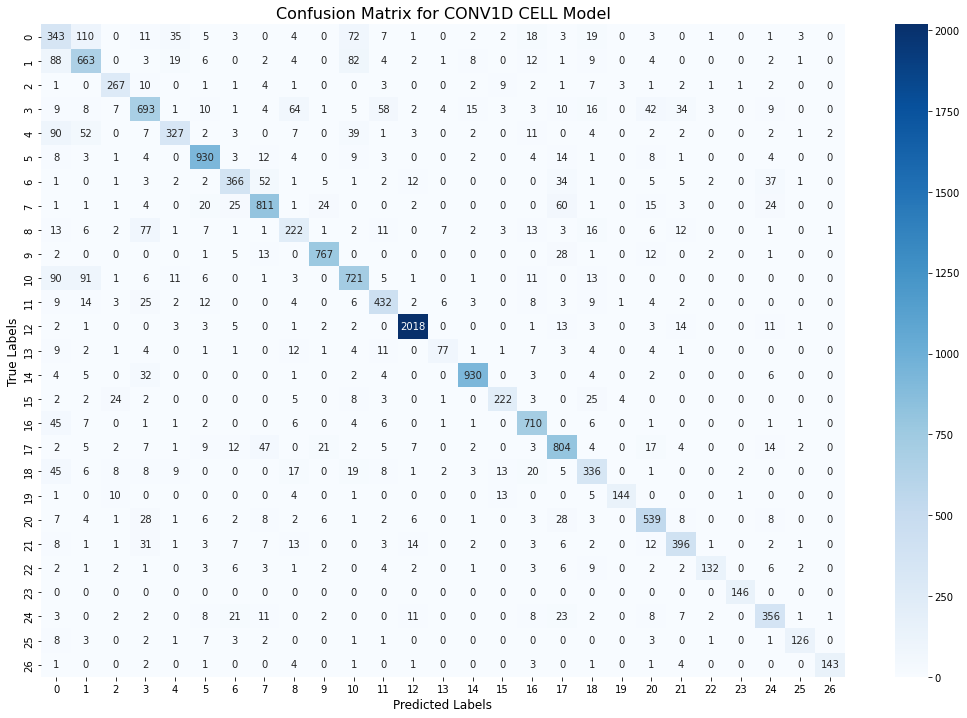

Wall time: 3.34 s


In [13]:
%%time

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test.values)

# Print evaluation results
print(f"[✔] Test Loss: {test_loss:.4f}")
print(f"[✔] Test Accuracy: {test_accuracy:.4f}")

# Predict class probabilities on the test set
y_pred = model.predict(X_test)

# Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=-1)

# Compute weighted F1-score manually
test_f1 = f1_score(y_test, y_pred_classes, average='weighted', zero_division=0)
print(f"[✔] Test Weighted F1-Score (computed manually): {test_f1:.4f}")

# Print classification report
print("\n[✔] Classification Report:")
print(classification_report(y_test, y_pred_classes,zero_division=0))

# Compute confusion matrix
conf_matrix_df_raw = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(18, 12))
sns.heatmap(conf_matrix_df_raw, annot=True, fmt='g', cmap='Blues', xticklabels=np.arange(27), yticklabels=np.arange(27))

# 6. Add titles and labels
plt.title('Confusion Matrix for CONV1D CELL Model', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)

# Show the plot
plt.show()


## 5. Customized Model Performance Analysis

This section outlines our comprehensive evaluation of the model’s classification performance, structured as follows:

- **5.1 Customized Classification Report:**  
  We start by mapping the training class numbers to the original class numbers and labels, providing clarity on performance metrics across the original categories.

- **5.2 Classification Report Generation & Class Categorization:**  
  Here, we categorize classes based on their F1-scores using thresholds derived from the Rakuten benchmark (weighted F1-score = 0.8113). This approach helps us distinguish classes that are well-classified, moderately classified, or poorly classified, thereby pinpointing areas for targeted improvement.

- **5.3 Consolidated Misclassification Report:**  
  We then dive deeper into prediction errors with a multi-layered analysis that includes:  
  - **5.3.1 Confusion Matrix Visualization with Mapped Labels:** Visualizing misclassification patterns by aligning training class numbers with the original labels.  
  - **5.3.2 Breakdown of Misclassifications:** Identifying common misclassification trends and frequently confused classes. 
  - **5.3.3 Detailed Misclassification Statistics:** Providing error counts and misclassification rates to highlight areas where the model underperforms.

This structured approach allows us to quickly identify strengths and focus on specific areas for improvement.


###  5.1 Customized Classification Report with Mapped Classes and Original Labels

In [14]:
import importlib
import src.model_evaluation  # Initial import
importlib.reload(config)  # Force reload the module
importlib.reload(src.model_evaluation)  # Force reload the module

from src.model_evaluation import process_classification_report
# import config

# Generate and process the classification report
classification_df, summary_rows, accuracy_value, accuracy_support = process_classification_report(
    y_test, y_pred_classes, config.PRDTYPECODE_MAPPING_PATH
)

# Display accuracy separately
print(f"\n[✔] Accuracy: {accuracy_value:.2f} (on {accuracy_support} samples)\n")

# Display final classification summary
print("\n[✔] Classification Summary Rows")
display(summary_rows)

# Display processed classification report
print("\n[✔] Processed Classification Report with Mapped Classes and Original Labels")
display(classification_df.tail(27))


[✔] Accuracy: 0.80 (on 16984 samples)


[✔] Classification Summary Rows


,Metric Type,precision,recall,f1-score,support
28,macro avg,0.80,0.77,0.79,16984
29,weighted avg,0.81,0.80,0.80,16984



[✔] Processed Classification Report with Mapped Classes and Original Labels


,Encoded target,Original prdtypecode,Label,precision,recall,f1-score,support
0,0,10,Adult Books,0.43,0.53,0.48,643
1,1,2280,Magazines,0.67,0.73,0.70,911
2,2,50,Video Games Accessories,0.80,0.84,0.82,319
3,3,1280,Toys for Children,0.72,0.69,0.71,1002
4,4,2705,Books,0.79,0.59,0.67,557
5,5,2522,Stationery,0.89,0.92,0.90,1011
6,6,2582,"Furniture, Kitchen, and Garden",0.79,0.69,0.73,533
7,7,1560,Interior Furniture and Bedding,0.83,0.82,0.82,993
8,8,1281,Board Games,0.58,0.54,0.56,408
9,9,1920,Interior Accessories,0.92,0.92,0.92,832


### 5.2 Generating a Customized Classification Report & Categorizing Classes

To assess performance, classes are categorized based on their **F1-scores** using thresholds defined relative to the **Rakuten benchmark** (RNN on text data, weighted F1-score = **0.8113**). These thresholds are designed to pinpoint areas for improvement and align with industry standards:

- **Well-classified:** **F1 ≥ Benchmark (e.g., 0.80)** – Categories that perform on par with or better than the reference model.
- **Moderately classified:** **Threshold_lower ≤ F1 < Benchmark** – Categories that may require further refinement.
- **Poorly classified:** **F1 < Threshold_lower** – Categories with notable misclassification issues.

These thresholds are **customizable** and will be adjusted based on results from baseline models in this challenge.


In [15]:
import importlib
import src.model_evaluation  # Initial import
import src.display # Initial import

importlib.reload(config)  # Force reload the module
importlib.reload(src.model_evaluation)  # Force reload the module
importlib.reload(src.display)  # Force reload the module
from src.model_evaluation import analyze_classification_performance, process_classification_report
from src.display import display_dataframe_to_user  # Import de la fonction

# Generate and process the classification report
classification_df, summary_rows, accuracy_value, accuracy_support = process_classification_report(
    y_test, y_pred_classes, config.PRDTYPECODE_MAPPING_PATH
)


# Define classification thresholds
WELL_CLASSIFIED_THRESHOLD = 0.80
MODERATELY_CLASSIFIED_THRESHOLD = 0.50

# Run classification performance analysis with dynamic thresholds
category_counts, well_classified, moderately_classified, poorly_classified = analyze_classification_performance(
    classification_df, 
    well_classified_threshold=WELL_CLASSIFIED_THRESHOLD, 
    moderately_classified_threshold=MODERATELY_CLASSIFIED_THRESHOLD
)

# Display summary based on dynamic thresholds
print("\n[✔] Summary of Classification Performance:")
print(f"- {category_counts.get('Well-classified', 0)} classes have an F1-score ≥ {WELL_CLASSIFIED_THRESHOLD:.2f} (Well-classified)")
print(f"- {category_counts.get('Moderate', 0)} classes have an F1-score between {MODERATELY_CLASSIFIED_THRESHOLD:.2f} and {WELL_CLASSIFIED_THRESHOLD:.2f} (Moderately classified)")
print(f"- {category_counts.get('Poorly classified', 0)} classes have an F1-score < {MODERATELY_CLASSIFIED_THRESHOLD:.2f} (Poorly classified)")


# Display detailed classification breakdown
# If `display_rows` is None (default), the entire DataFrame is shown; otherwise, it limits to `display_rows`.
display_dataframe_to_user(
    name=f"Well-Classified Categories (F1 ≥ {WELL_CLASSIFIED_THRESHOLD:.2f})",
    dataframe=well_classified.sort_values(by="f1-score", ascending=False), display_rows=None
)

display_dataframe_to_user(
    name=f"Moderately Classified Categories ({MODERATELY_CLASSIFIED_THRESHOLD:.2f} ≤ F1 < {WELL_CLASSIFIED_THRESHOLD:.2f})",
    dataframe=moderately_classified.sort_values(by="f1-score", ascending=False), display_rows=None
)

display_dataframe_to_user(
    name=f"Poorly Classified Categories (F1 < {MODERATELY_CLASSIFIED_THRESHOLD:.2f})",
    dataframe=poorly_classified.sort_values(by="f1-score", ascending=True),display_rows=None
)




[✔] Summary of Classification Performance:
- 12 classes have an F1-score ≥ 0.80 (Well-classified)
- 14 classes have an F1-score between 0.50 and 0.80 (Moderately classified)
- 1 classes have an F1-score < 0.50 (Poorly classified)

Well-Classified Categories (F1 ≥ 0.80): (showing all rows)



,Encoded target,Original prdtypecode,Label,precision,recall,f1-score,support,Quality Classification
23,23,2905,Online Distribution of Video Games,0.97,1.00,0.99,146,Well-classified
12,12,2583,Piscine and Spa,0.97,0.97,0.97,2083,Well-classified
14,14,1300,Remote Controlled Models,0.95,0.94,0.94,993,Well-classified
26,26,1301,Accessories for Children,0.97,0.88,0.93,162,Well-classified
9,9,1920,Interior Accessories,0.92,0.92,0.92,832,Well-classified
5,5,2522,Stationery,0.89,0.92,0.90,1011,Well-classified
19,19,60,Games and Consoles,0.95,0.80,0.87,179,Well-classified
16,16,1160,Playing Cards,0.84,0.90,0.86,793,Well-classified
25,25,1940,Food,0.90,0.79,0.84,159,Well-classified
2,2,50,Video Games Accessories,0.80,0.84,0.82,319,Well-classified



Moderately Classified Categories (0.50 ≤ F1 < 0.80): (showing all rows)



,Encoded target,Original prdtypecode,Label,precision,recall,f1-score,support,Quality Classification
20,20,1320,Early Childhood,0.78,0.81,0.79,664,Moderate
22,22,2220,Supplies for Domestic Animals,0.91,0.69,0.79,190,Moderate
15,15,2462,Games,0.83,0.74,0.78,301,Moderate
21,21,1302,"Toys, Outdoor Playing, and Clothes",0.80,0.77,0.78,514,Moderate
11,11,1140,Figurines and Toy Pop,0.75,0.79,0.77,545,Moderate
10,10,2403,Children Books and Magazines,0.73,0.75,0.74,961,Moderate
24,24,2585,Gardening and DIY,0.73,0.76,0.74,468,Moderate
6,6,2582,"Furniture, Kitchen, and Garden",0.79,0.69,0.73,533,Moderate
3,3,1280,Toys for Children,0.72,0.69,0.71,1002,Moderate
1,1,2280,Magazines,0.67,0.73,0.70,911,Moderate



Poorly Classified Categories (F1 < 0.50): (showing all rows)



,Encoded target,Original prdtypecode,Label,precision,recall,f1-score,support,Quality Classification
0,0,10,Adult Books,0.43,0.53,0.48,643,Poorly classified


 ### 5.3 Analyzing Misclassification Errors: A Consolidated Report

### 5.3.1 Confusion Matrix Visualization with Mapped Labels
→ Display the confusion matrix with mapped labels to visualize misclassification patterns.

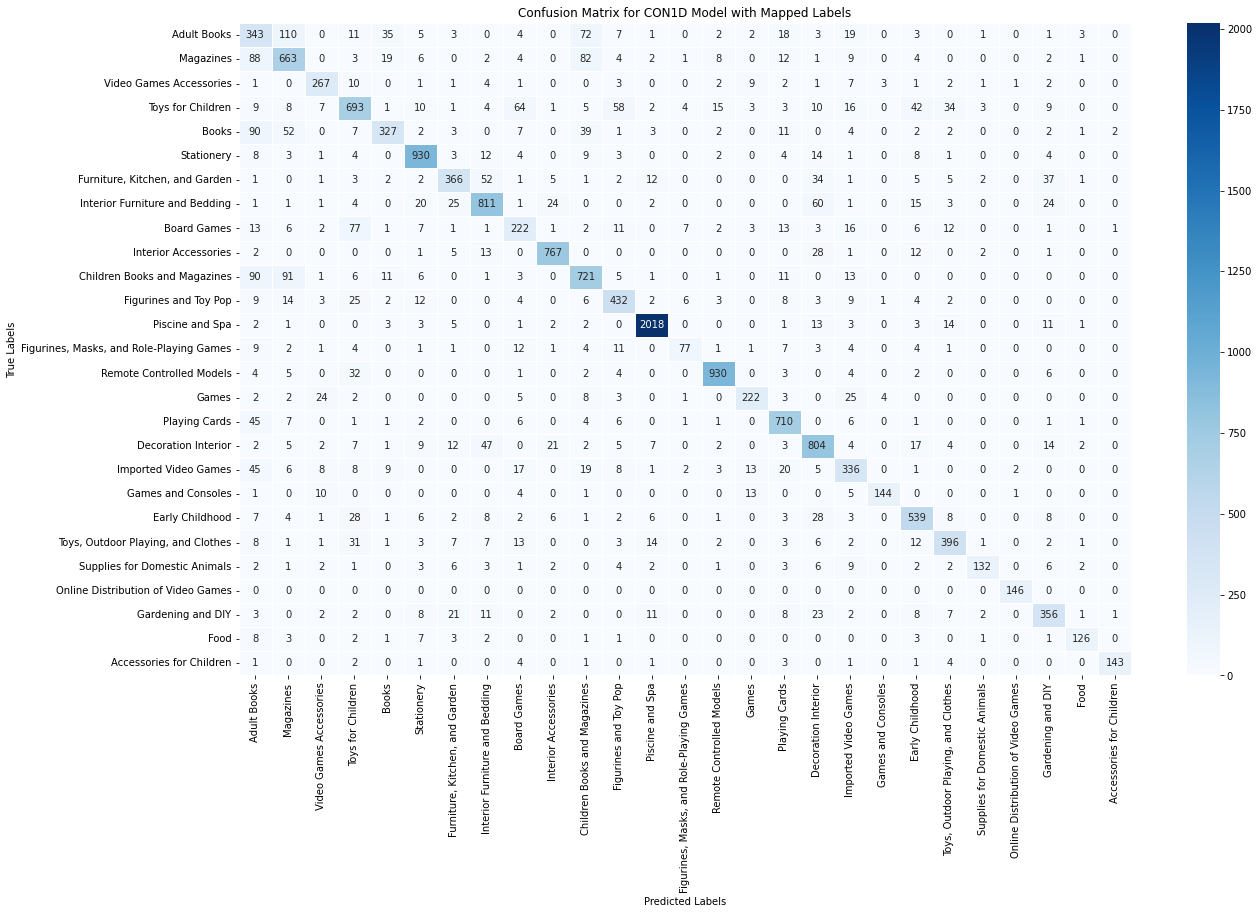

In [16]:
import importlib
importlib.reload(config)  # Reload config to ensure any updates are applied
import src.model_evaluation  # Initial import

importlib.reload(src.model_evaluation)  # Force reload the module
from src.model_evaluation import generate_confusion_matrix  

# Generate the confusion matrix with mapped labels
conf_matrix_df_labeled = generate_confusion_matrix(y_test, y_pred_classes, config.PRDTYPECODE_MAPPING_PATH)

# Display the confusion matrix as a heatmap
plt.figure(figsize=(20, 12))
sns.heatmap(conf_matrix_df_labeled, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for CON1D Model with Mapped Labels")
plt.show()


### 5.3.2 Breakdown of Misclassifications  
→ **Analyze misclassification trends, identify the most frequently misclassified classes, and assess overall model performance.**  

In this section, we analyze the model’s misclassification patterns using a structured approach.  
We present four breakdowns to understand where the model struggles the most.  

#### **Columns in the Misclassification Table:**  
- **Encoded target** → The encoded numerical representation of each class.  
- **Original prdtypecode** → The original product category code.  
- **Class Label** → The human-readable label of the class.  
- **Samples** → The total number of instances for each class.  
- **Misclassified Count** → The number of misclassified samples for the class.  
- **Misclassification Rate (%)** → The percentage of misclassified samples within the class.  
- **Global Misclassification Rate (%)** → The percentage of misclassified samples relative to the total dataset.  

####  **Key Misclassification Perspectives**  

1. **Classes with the highest number of samples**  
   - Shows the most **frequent classes** in the dataset.  
   - Helps assess whether a class’s misclassification is due to **its high occurrence** or **its inherent difficulty**.  
   - Large classes can dominate misclassification counts even if their misclassification rate is low.  

2. **Classes with the highest number of misclassifications**  
   - Highlights the classes with the **largest absolute number of errors**.  
   - Useful for identifying which classes **contribute the most errors**, regardless of their misclassification rate.  
   - A class with many misclassifications may indicate **model weakness** or **data imbalance**.  

3. **Classes with the highest misclassification rate (%)**  
   - Identifies the classes where the model **struggles the most** proportionally.  
   - A high rate suggests **systematic confusion** in distinguishing this class from others.  
   - Small classes with a **high error rate** might require **better feature representation** or **more training data**.  

4. **Classes contributing the most to overall misclassification (%)**  
   - Measures **each class’s impact on total model errors**.  
   - A class with **many samples and a moderate error rate** can still contribute significantly to overall misclassification.  
   - Helps prioritize which classes should be improved to **reduce total model error** the most.  


By examining these four aspects, we gain insights into both **systematic classification errors** and **dataset imbalances** that could be influencing the model’s performance.  


In [17]:
import importlib

importlib.reload(config)
import src.model_evaluation  # Initial import
importlib.reload(src.model_evaluation)
from src.model_evaluation import analyze_and_display_misclassification

# Calculs déjà réalisés
misclassified_counts = conf_matrix_df_labeled.sum(axis=1) - np.diag(conf_matrix_df_labeled)
total_samples_per_class = conf_matrix_df_labeled.sum(axis=1)
misclassification_rates = round((misclassified_counts / total_samples_per_class) * 100, 2)

# [✔]Call the function with a custom number of rows to display
# You can set `display_rows` to control how many rows are shown in the notebook.
# By default, it displays 10 rows.
misclassification_analysis_df = analyze_and_display_misclassification(
    y_test, y_pred_classes, misclassified_counts, total_samples_per_class, misclassification_rates, display_rows=10
)


[✔] Misclassification analysis DataFrame created!

Top classes with the highest number of samples: (showing up to 10 rows)



,Encoded target,Original prdtypecode,Class Label,Samples,Misclassified Count,Misclassification Rate (%),Global Misclassification Rate (%)
12,12,2583,Piscine and Spa,2083,65,3.12,0.38
5,5,2522,Stationery,1011,81,8.01,0.48
3,3,1280,Toys for Children,1002,309,30.84,1.82
7,7,1560,Interior Furniture and Bedding,993,182,18.33,1.07
14,14,1300,Remote Controlled Models,993,63,6.34,0.37
17,17,2060,Decoration Interior,970,166,17.11,0.98
10,10,2403,Children Books and Magazines,961,240,24.97,1.41
1,1,2280,Magazines,911,248,27.22,1.46
9,9,1920,Interior Accessories,832,65,7.81,0.38
16,16,1160,Playing Cards,793,83,10.47,0.49



Top classes with the highest number of misclassifications: (showing up to 10 rows)



,Encoded target,Original prdtypecode,Class Label,Samples,Misclassified Count,Misclassification Rate (%),Global Misclassification Rate (%)
3,3,1280,Toys for Children,1002,309,30.84,1.82
0,0,10,Adult Books,643,300,46.66,1.77
1,1,2280,Magazines,911,248,27.22,1.46
10,10,2403,Children Books and Magazines,961,240,24.97,1.41
4,4,2705,Books,557,230,41.29,1.35
8,8,1281,Board Games,408,186,45.59,1.10
7,7,1560,Interior Furniture and Bedding,993,182,18.33,1.07
6,6,2582,"Furniture, Kitchen, and Garden",533,167,31.33,0.98
18,18,40,Imported Video Games,503,167,33.20,0.98
17,17,2060,Decoration Interior,970,166,17.11,0.98



Top classes with the highest misclassification rate (%): (showing up to 10 rows)



,Encoded target,Original prdtypecode,Class Label,Samples,Misclassified Count,Misclassification Rate (%),Global Misclassification Rate (%)
0,0,10,Adult Books,643,300,46.66,1.77
13,13,1180,"Figurines, Masks, and Role-Playing Games",144,67,46.53,0.39
8,8,1281,Board Games,408,186,45.59,1.10
4,4,2705,Books,557,230,41.29,1.35
18,18,40,Imported Video Games,503,167,33.20,0.98
6,6,2582,"Furniture, Kitchen, and Garden",533,167,31.33,0.98
3,3,1280,Toys for Children,1002,309,30.84,1.82
22,22,2220,Supplies for Domestic Animals,190,58,30.53,0.34
1,1,2280,Magazines,911,248,27.22,1.46
15,15,2462,Games,301,79,26.25,0.47



Top classes contributing the most to overall misclassification (%): (showing up to 10 rows)



,Encoded target,Original prdtypecode,Class Label,Samples,Misclassified Count,Misclassification Rate (%),Global Misclassification Rate (%)
3,3,1280,Toys for Children,1002,309,30.84,1.82
0,0,10,Adult Books,643,300,46.66,1.77
1,1,2280,Magazines,911,248,27.22,1.46
10,10,2403,Children Books and Magazines,961,240,24.97,1.41
4,4,2705,Books,557,230,41.29,1.35
8,8,1281,Board Games,408,186,45.59,1.10
7,7,1560,Interior Furniture and Bedding,993,182,18.33,1.07
6,6,2582,"Furniture, Kitchen, and Garden",533,167,31.33,0.98
17,17,2060,Decoration Interior,970,166,17.11,0.98
18,18,40,Imported Video Games,503,167,33.20,0.98


### 5.3.3 Detailed Misclassification Statistics  
→ **Analyze individual misclassification cases, including total errors, misclassification rates, and overprediction trends.**  

####  Meaning of Columns in the Classification Error Analysis Table  

| **Column**                | **Description** |
|---------------------------|----------------|
| **True Label**            | The actual class of the sample in the test set (the correct category). |
| **Predicted Label**       | The incorrect class predicted by the model instead of the **True Label**. |
| **Count**                 | The number of times samples from **True Label** were misclassified as **Predicted Label**. |
| **Percentage**            | The proportion of this specific misclassification relative to **all misclassified instances**. Computed as: `(Count / Total Misclassified) * 100`. |
| **Class Sample Size** | The total number of test samples belonging to the **True Label** class (i.e., how many instances of this class exist in the test set). |
| **Misclassified Count**   | The total number of **True Label** samples that were misclassified (sum of all errors for this class). |
| **Misclassification Rate** | The error rate for the **True Label** class. Computed as: `(Misclassified Count /Class Sample Size) * 100`. |
| **Total Predicted**       | The total number of test samples predicted as belonging to the **Predicted Label** class (both correctly and incorrectly). |
| **Incorrect Predictions** | The number of test samples **incorrectly predicted** as **Predicted Label** (should have been a different class). |
| **Overprediction Rate**   | The proportion of incorrect predictions for the **Predicted Label** class. Computed as: `(Incorrect Predictions / Total Predicted) * 100`. |



In [18]:
importlib.reload(config) 
import src.model_evaluation  # Initial import
importlib.reload(src.model_evaluation)  # Force reload to use updated functions
from src.model_evaluation import generate_display_misclass_report

# Generate the enriched misclassification report
# NOTE: To display only a subset of rows, modify display_rows when calling the function
# Example: Use display_rows=20 to show only the top 20 rows:
misclassification_report = generate_display_misclass_report(
    y_test, y_pred_classes, config.PRDTYPECODE_MAPPING_PATH, display_rows=20 # Set top_n to an integer (e.g., 20) to limit rows
)

# # Display the final enriched report
# print("\n[✔] Consolidated Misclassification Report:")
# display(misclassification_report)


Misclassification Report: (showing up to 20 rows)



,True Label,Predicted Label,Count,Percentage,Class Sample Size,Misclassified Count,Misclassification Rate,Total Predicted,Incorrect Predictions,Overprediction Rate
0,Adult Books,Magazines,110,3.27%,643,300,46.66%,985,322,32.69%
1,Children Books and Magazines,Magazines,91,2.71%,961,240,24.97%,985,322,32.69%
2,Books,Adult Books,90,2.68%,557,230,41.29%,794,451,56.80%
3,Children Books and Magazines,Adult Books,90,2.68%,961,240,24.97%,794,451,56.80%
4,Magazines,Adult Books,88,2.62%,911,248,27.22%,794,451,56.80%
5,Magazines,Children Books and Magazines,82,2.44%,911,248,27.22%,982,261,26.58%
6,Board Games,Toys for Children,77,2.29%,408,186,45.59%,963,270,28.04%
7,Adult Books,Children Books and Magazines,72,2.14%,643,300,46.66%,982,261,26.58%
8,Toys for Children,Board Games,64,1.90%,1002,309,30.84%,381,159,41.73%
9,Interior Furniture and Bedding,Decoration Interior,60,1.78%,993,182,18.33%,1045,241,23.06%



[✔] Final Consolidated Report Generated!


### 5.4 **Exporting Classification Analysis to Excel** 

This step saves all classification insights into a **single Excel file** with multiple sheets for easy review.  

####  Exported Data Includes:
- **Well-Classified, Moderately Classified, Poorly Classified** categories (sorted by F1-score).  
- **Misclassification Analysis** (error rates, misclassified counts).  
- **Consolidated Misclassification Report** (detailed misclassification breakdown per class).  
- **Raw Confusion Matrix** (numerical values without labels).  

####  Output File Example:  
**`classification_analysis_<MODEL_NAME>_<TIMESTAMP>.xlsx`**  



In [19]:
import importlib
import src.model_evaluation  # Initial import
import src.export_utils  # # Initial import

importlib.reload(config) # Force reload module
importlib.reload(src.model_evaluation)  # Force reload module
importlib.reload(src.export_utils)  # Force reload module

from src.model_evaluation import analyze_and_display_misclassification, generate_display_misclass_report
from src.export_utils import export_all_analysis




# Define model name and file prefix
model_used = "CONV1D_Model"
file_prefix = "classification_analysis"

# Generate and process the classification report
classification_df, summary_rows, accuracy_value, accuracy_support = process_classification_report(
    y_test, y_pred_classes, config.PRDTYPECODE_MAPPING_PATH
)


# Convert conf_matrix_df_raw to Pandas DataFrame
conf_matrix_df = pd.DataFrame(conf_matrix_df_raw, 
                              index=[f"True Class {label}" for label in set(y_test)],  # Index as True Labels
                              columns=[f"Pred Class {label}" for label in set(y_pred_classes)])  # Columns as Predicted Labels



# Generates and displays misclassification analysis
full_misclassification_analysis_df = analyze_and_display_misclassification(y_test,
                                                                           y_pred_classes,
                                                                           misclassified_counts,
                                                                           total_samples_per_class,
                                                                           misclassification_rates,
                                                                           display_rows=None,
                                                                           display_output=False
)

#Generates and displays a comprehensive misclassification report combining multiple analyses
full_misclassification_report = generate_display_misclass_report(y_test,
                                                                 y_pred_classes,
                                                                 config.PRDTYPECODE_MAPPING_PATH,
                                                                 display_rows=None,
                                                                display_output=False
)



dataframes_to_export = {
    "Class Categorization": {
        f"Well-Classified (F1 ≥ {WELL_CLASSIFIED_THRESHOLD:.2f})": well_classified.sort_values(by="f1-score", ascending=False),
        f"Moderately Classified ({MODERATELY_CLASSIFIED_THRESHOLD:.2f} ≤ F1 < {WELL_CLASSIFIED_THRESHOLD:.2f})": moderately_classified.sort_values(by="f1-score", ascending=False),
        f"Poorly Classified (F1 < {MODERATELY_CLASSIFIED_THRESHOLD:.2f})": poorly_classified.sort_values(by="f1-score", ascending=True),
    },
    "Misclassification Analysis": full_misclassification_analysis_df,
    "Consolidated Misclassification Report": full_misclassification_report,
    "Raw Confusion Matrix": conf_matrix_df
}

# Export all the data
export_path = export_all_analysis(
    dataframes_dict=dataframes_to_export,
    model_name=model_used,
    file_prefix=file_prefix,
    mode="text",
    classification_df=classification_df,
    summary_rows=summary_rows,
    accuracy_value=accuracy_value,
    accuracy_support=accuracy_support
)

# Print confirmation
print(f"\n[✔] Full classification analysis saved to: {export_path}")

[✔] Misclassification analysis DataFrame created!

[✔] Final Consolidated Report Generated!

[✔] Full classification analysis saved to: D:\Data_Science\Append_Data_Engineer_AWS_MLOPS\Data_Scientist_Rakuten_Project-main\reports\classification_reports\text\classification_analysis_CONV1D_Model_2025-02-25_15-08-01.xlsx


## 6. Hyperparameter Tuning
Fine-tuning the model by testing multiple hyperparameter configurations to optimize performance.

### 6.1 Testing Multiple Configurations  
- Define a hyperparameter grid (`dropout`, `L2 regularization`, `learning rate`, `patience`).  
- Train and evaluate multiple models with different configurations.  
- Store and compare the results based on validation accuracy and loss.

In [25]:

# Define hyperparameter grid
param_grid = [
    {"dropout": 0.3, "l2_reg": 0.001, "learning_rate": 0.001, "patience": 2},
    {"dropout": 0.4, "l2_reg": 0.0005, "learning_rate": 0.0005, "patience": 2},
    {"dropout": 0.5, "l2_reg": 0.001, "learning_rate": 0.0003, "patience": 3},
    {"dropout": 0.3, "l2_reg": 0.0001, "learning_rate": 0.0005, "patience": 2}
]

# Store results
results = []

for params in param_grid:
    print(f"\n🔹 Training with params: {params}\n")

    # Build the model
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=maxlen),
        SpatialDropout1D(params["dropout"]),
        Conv1D(64, 2, activation='relu', kernel_regularizer=l2(params["l2_reg"])),
        GlobalMaxPooling1D(),
        Dense(256, activation='relu', kernel_regularizer=l2(params["l2_reg"])),
        Dropout(params["dropout"]),
        Dense(27, activation='softmax')
    ])

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=params["learning_rate"]),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Define Early Stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=params["patience"],
        restore_best_weights=True
    )

    # Train the model
    history = model.fit(
        X_train, y_train.values,
        batch_size=200,
        epochs=50,  # Let early stopping decide when to stop
        validation_data=(X_test, y_test.values),
        callbacks=[early_stopping],
        verbose=1
    )

    # Get the best epoch results
    best_epoch = np.argmin(history.history['val_loss']) + 1  # Best epoch (1-based index)
    final_train_acc = history.history['accuracy'][best_epoch - 1]
    final_val_acc = history.history['val_accuracy'][best_epoch - 1]
    final_val_loss = history.history['val_loss'][best_epoch - 1]

    # Store results
    results.append({
        "dropout": params["dropout"],
        "l2_reg": params["l2_reg"],
        "learning_rate": params["learning_rate"],
        "patience": params["patience"],
        "best_epoch": best_epoch,
        "train_acc": round(final_train_acc, 4),
        "val_acc": round(final_val_acc, 4),
        "val_loss": round(final_val_loss, 4)
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)
print("\n🔍 **Comparison of Different Configurations:**")
display(results_df.sort_values(by="val_acc", ascending=False))



🔹 Training with params: {'dropout': 0.3, 'l2_reg': 0.001, 'learning_rate': 0.001, 'patience': 2}

Epoch 1/50
340/340 [==============================] - 5s 11ms/step - loss: 2.1849 - accuracy: 0.4069 - val_loss: 1.3900 - val_accuracy: 0.6502
Epoch 2/50
340/340 [==============================] - 3s 9ms/step - loss: 1.1892 - accuracy: 0.7027 - val_loss: 1.0766 - val_accuracy: 0.7294
Epoch 3/50
340/340 [==============================] - 3s 9ms/step - loss: 0.9221 - accuracy: 0.7793 - val_loss: 0.9756 - val_accuracy: 0.7633
Epoch 4/50
340/340 [==============================] - 3s 9ms/step - loss: 0.7702 - accuracy: 0.8240 - val_loss: 0.9390 - val_accuracy: 0.7729
Epoch 5/50
340/340 [==============================] - 3s 9ms/step - loss: 0.6679 - accuracy: 0.8520 - val_loss: 0.9268 - val_accuracy: 0.7774
Epoch 6/50
340/340 [==============================] - 3s 8ms/step - loss: 0.5883 - accuracy: 0.8740 - val_loss: 0.9220 - val_accuracy: 0.7823
Epoch 7/50
340/340 [============================

,dropout,l2_reg,learning_rate,patience,best_epoch,train_acc,val_acc,val_loss
3,0.3,0.0001,0.0005,2,5,0.8448,0.7894,0.7831
1,0.4,0.0005,0.0005,2,7,0.8441,0.7848,0.8881
0,0.3,0.0010,0.0010,2,6,0.8740,0.7823,0.9220
2,0.5,0.0010,0.0003,3,19,0.8590,0.7728,0.9897


### 6.2 Selecting the Best Configuration  
- Identify the best performing model based on validation accuracy and loss.  
- Best configuration obtained:  
  - **Dropout:** 0.3  
  - **L2 Regularization:** 0.0001  
  - **Learning Rate:** 0.0005  
  - **Patience:** 2  

### 6.3 Training the Final Model (Version 1)  
- Train the final model using the selected best hyperparameters.  
- Apply early stopping to prevent overfitting.

In [42]:


# Define best hyperparameters
BEST_DROPOUT = 0.3
BEST_L2_REG = 0.0001
BEST_LR = 0.0005
BEST_PATIENCE = 2

# Build the final model
final_model = Sequential([
    # Embedding Layer
    Embedding(vocab_size, embedding_dim, input_length=maxlen),
    SpatialDropout1D(BEST_DROPOUT),  # Dropout in Embedding layer

    # Conv1D Layer with L2 Regularization
    Conv1D(64, 2, activation='relu', kernel_regularizer=l2(BEST_L2_REG)),
    GlobalMaxPooling1D(),

    # Fully Connected Layer
    Dense(256, activation='relu', kernel_regularizer=l2(BEST_L2_REG)),
    Dropout(BEST_DROPOUT),  # Dropout in dense layer

    # Output Layer
    Dense(27, activation='softmax')  # Multi-class classification
])

# Compile the model
final_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=BEST_LR),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Define Early Stopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=BEST_PATIENCE,
    restore_best_weights=True
)

# Train the final model
history_final_model = final_model.fit(
    X_train, 
    y_train.values, 
    batch_size=200, 
    epochs=50,  # Let EarlyStopping decide when to stop
    validation_data=(X_test, y_test.values),
    callbacks=[early_stopping],
    verbose=1
)

# # Save the final trained model
# final_model.save("final_conv1d_model.h5")
# print("\n[✔] Final model saved as 'final_conv1d_model.h5'!")


Epoch 1/50
340/340 [==============================] - 4s 10ms/step - loss: 2.3568 - accuracy: 0.3371 - val_loss: 1.5608 - val_accuracy: 0.5573
Epoch 2/50
340/340 [==============================] - 3s 9ms/step - loss: 1.2535 - accuracy: 0.6482 - val_loss: 1.0089 - val_accuracy: 0.7239
Epoch 3/50
340/340 [==============================] - 3s 9ms/step - loss: 0.8719 - accuracy: 0.7605 - val_loss: 0.8536 - val_accuracy: 0.7658
Epoch 4/50
340/340 [==============================] - 3s 8ms/step - loss: 0.6918 - accuracy: 0.8124 - val_loss: 0.7954 - val_accuracy: 0.7829
Epoch 5/50
340/340 [==============================] - 3s 9ms/step - loss: 0.5785 - accuracy: 0.8462 - val_loss: 0.7840 - val_accuracy: 0.7891
Epoch 6/50
340/340 [==============================] - 3s 9ms/step - loss: 0.4982 - accuracy: 0.8679 - val_loss: 0.7844 - val_accuracy: 0.7911
Epoch 7/50
340/340 [==============================] - 3s 9ms/step - loss: 0.4344 - accuracy: 0.8880 - val_loss: 0.7933 - val_accuracy: 0.7921


### 6.4 Evaluating the Final Model (Version 1) 

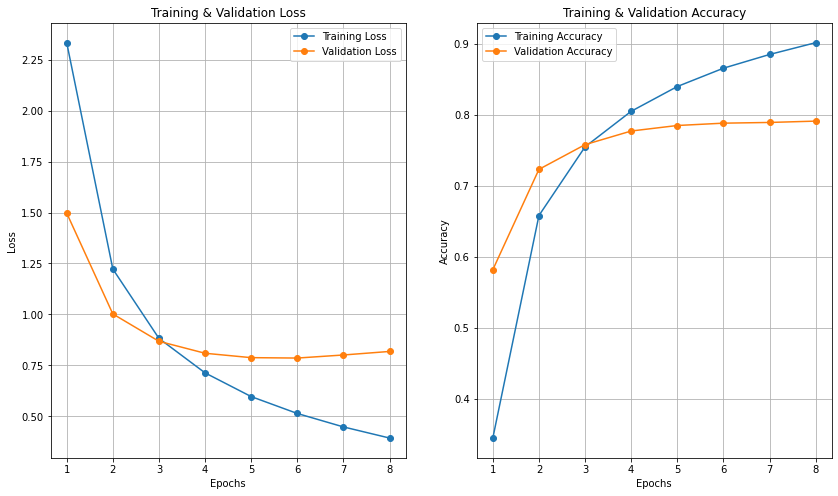

In [29]:
def plot_learning_curves(history):
    """
    Plots training & validation loss and accuracy over epochs.
    
    Args:
        history: Can be either:
            - A Keras `History` object (from model.fit())
            - A reloaded dictionary (from a JSON file)
    """

    # Check if `history` is a Keras History object
    if isinstance(history, tf.keras.callbacks.History):
        history_data = history.history  # Extract dictionary
    elif isinstance(history, dict):
        history_data = history  # Already a dictionary
    else:
        print("[X] Invalid `history` format. Expected a Keras History object or a dictionary.")
        return

    # Extract values
    epochs = range(1, len(history_data['loss']) + 1)
    train_loss = history_data['loss']
    val_loss = history_data['val_loss']
    train_acc = history_data['accuracy']
    val_acc = history_data['val_accuracy']

    # Plot Loss Curve
    plt.figure(figsize=(14, 8))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Training Loss', marker='o')
    plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Training Accuracy', marker='o')
    plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.show()

# Example usage after training
plot_learning_curves(history_final_model)  # Works with a Keras History object



In [34]:
test_loss, test_acc = final_model.evaluate(X_test, y_test.values)
print(f"\n[✔] Test Accuracy: {test_acc:.4f}")

531/531 [==============================] - 2s 3ms/step - loss: 0.7859 - accuracy: 0.7879

[✔] Test Accuracy: 0.7879


In [35]:
y_pred_classes = final_model.predict(X_test).argmax(axis=-1)
print(classification_report(y_test, y_pred_classes))

531/531 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.39      0.52      0.44       643
           1       0.66      0.67      0.66       911
           2       0.76      0.82      0.79       319
           3       0.71      0.70      0.70      1002
           4       0.73      0.56      0.63       557
           5       0.90      0.90      0.90      1011
           6       0.72      0.71      0.71       533
           7       0.81      0.83      0.82       993
           8       0.61      0.51      0.56       408
           9       0.88      0.92      0.90       832
          10       0.73      0.74      0.74       961
          11       0.75      0.78      0.76       545
          12       0.96      0.97      0.97      2083
          13       0.64      0.52      0.57       144
          14       0.94      0.94      0.94       993
          15       0.79      0.75      0.77       301
          16       0.85   

###  Base Model vs. Final Model (Version 1)  (F1-Score & Test Performance)


| **Metric**              | **Base Model** | **Fine-Tuned Model** | **Change** |
|-------------------------|--------------|----------------|----------------|
| **Test Accuracy**       | **80.20%**   | **79.00%**     | 🔻 **(-1.2%)** |
| **Weighted F1-Score**   | **0.8025**   | **0.79**       | 🔻 **(-1.25%)** |
| **Macro F1-Score**      | **0.79**     | **0.76**       | 🔻 **(-3%)** |
| **Validation Accuracy** | **~80%**     | **~80%**       | ➖ **No significant change** |


###  📌 Observations
#### **1️⃣ Slight Drop in Accuracy & F1-Score (-1.2%)**
- The fine-tuned model is slightly worse than the base model in accuracy.
- The macro F1-score dropped from 0.79 to 0.76, indicating a bigger drop in underrepresented classes.
#### **2️⃣ Some Classes Lost Performance**
- Class 0 (Books): F1-score dropped from 0.48 → 0.44
- Class 22 (Supplies for Domestic Animals): F1-score dropped from 0.79 → 0.70
- Class 25 (Food): F1-score dropped from 0.84 → 0.75
- These suggest that some classes suffered from increased regularization, making predictions more conservative.
#### **3️⃣ Better Stability, But Slightly Weaker Performance**
- Validation accuracy is stable at ~80%, meaning the fine-tuned model isn’t overfitting anymore.
- , it became slightly underconfident, leading to lower recall for some classes


### **🚀 Next Steps: How to Improve?**

#### **1️⃣ Reduce Regularization Slightly (Balance Stability & Performance)**
✔ **Lower Dropout** from `0.3 → 0.2`  
✔ **Reduce L2 Regularization** from `0.0001 → 0.00005`  
✔ **Maintain Early Stopping** at `patience=2`  

#### **2️⃣ Experiment with Class Weights**  
🔹 Some **underrepresented classes** (e.g., **Class 22, Class 25**) saw a **drop in recall**.  
🔹 **Solution:** Assign **higher class weights** to penalize incorrect predictions more.  



### 6.5 Further Refinement & Training Final Model (Version 2)  

In [ ]:
### 6.5 Final Model Training with Best Configuration
- Best Configuration obtained
- dropout: 0.2 
- l2_reg:0.00005 
- learning_rate: 0.0005  
- patience: 2 


In [37]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Updated hyperparameters
BEST_DROPOUT = 0.2  # Lowered from 0.3 → 0.2
BEST_L2_REG = 0.00005  # Reduced from 0.0001 → 0.00005
BEST_LR = 0.0005  # Keeping same learning rate
BEST_PATIENCE = 2  # Maintaining early stopping patience

#  Build the updated final model
final_model_v2 = Sequential([
    # Embedding Layer
    Embedding(vocab_size, embedding_dim, input_length=maxlen),
    SpatialDropout1D(BEST_DROPOUT),  # Lower dropout in Embedding layer

    # Conv1D Layer with L2 Regularization
    Conv1D(64, 2, activation='relu', kernel_regularizer=l2(BEST_L2_REG)),
    GlobalMaxPooling1D(),

    # Fully Connected Layer
    Dense(256, activation='relu', kernel_regularizer=l2(BEST_L2_REG)),
    Dropout(BEST_DROPOUT),  # Lower dropout in dense layer

    # Output Layer
    Dense(27, activation='softmax')  # Multi-class classification
])

# Compile the model
final_model_v2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=BEST_LR),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Define Early Stopping Callback
early_stopping_v2 = EarlyStopping(
    monitor='val_loss',
    patience=BEST_PATIENCE,
    restore_best_weights=True
)

#  Train the updated model
history_final_model_v2 = final_model_v2.fit(
    X_train, 
    y_train.values, 
    batch_size=200, 
    epochs=50,  # Let EarlyStopping decide when to stop
    validation_data=(X_test, y_test.values),
    callbacks=[early_stopping_v2],
    verbose=1
)

# #  Save the updated final model
# final_model_v2.save("final_conv1d_model_v2.h5")
# print("\n[✔] Final model saved as 'final_conv1d_model_v2.h5'!")


Epoch 1/50
340/340 [==============================] - 4s 10ms/step - loss: 2.2460 - accuracy: 0.3697 - val_loss: 1.3964 - val_accuracy: 0.6123
Epoch 2/50
340/340 [==============================] - 3s 8ms/step - loss: 1.1020 - accuracy: 0.6914 - val_loss: 0.9333 - val_accuracy: 0.7371
Epoch 3/50
340/340 [==============================] - 3s 8ms/step - loss: 0.7714 - accuracy: 0.7820 - val_loss: 0.8173 - val_accuracy: 0.7690
Epoch 4/50
340/340 [==============================] - 3s 9ms/step - loss: 0.6070 - accuracy: 0.8303 - val_loss: 0.7829 - val_accuracy: 0.7790
Epoch 5/50
340/340 [==============================] - 3s 9ms/step - loss: 0.4925 - accuracy: 0.8651 - val_loss: 0.7747 - val_accuracy: 0.7875
Epoch 6/50
340/340 [==============================] - 3s 8ms/step - loss: 0.4077 - accuracy: 0.8908 - val_loss: 0.7931 - val_accuracy: 0.7907
Epoch 7/50
340/340 [==============================] - 3s 8ms/step - loss: 0.3436 - accuracy: 0.9108 - val_loss: 0.8139 - val_accuracy: 0.7891


### 6.6 Evaluating the Final Model (Version 2)  

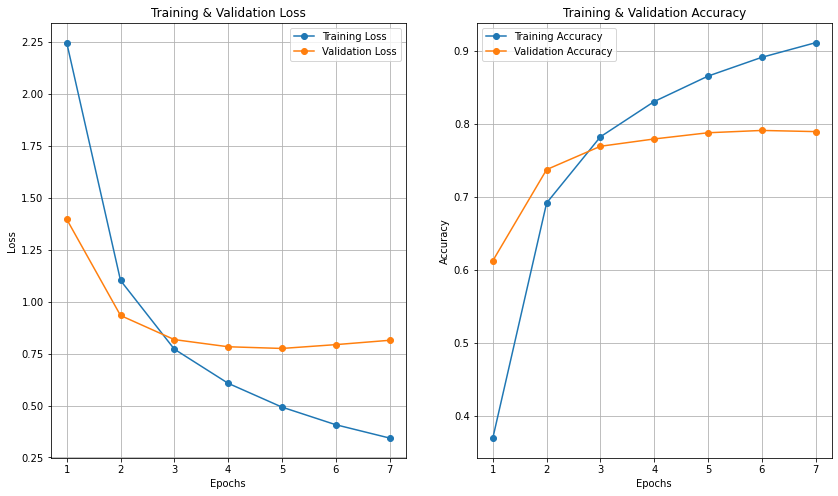

In [38]:
def plot_learning_curves(history):
    """
    Plots training & validation loss and accuracy over epochs.
    
    Args:
        history: Can be either:
            - A Keras `History` object (from model.fit())
            - A reloaded dictionary (from a JSON file)
    """

    # Check if `history` is a Keras History object
    if isinstance(history, tf.keras.callbacks.History):
        history_data = history.history  # Extract dictionary
    elif isinstance(history, dict):
        history_data = history  # Already a dictionary
    else:
        print("[X] Invalid `history` format. Expected a Keras History object or a dictionary.")
        return

    # Extract values
    epochs = range(1, len(history_data['loss']) + 1)
    train_loss = history_data['loss']
    val_loss = history_data['val_loss']
    train_acc = history_data['accuracy']
    val_acc = history_data['val_accuracy']

    # Plot Loss Curve
    plt.figure(figsize=(14, 8))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Training Loss', marker='o')
    plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Training Accuracy', marker='o')
    plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.show()

# Example usage after training
plot_learning_curves(history_final_model_v2)  # Works with a Keras History object



In [40]:
test_loss, test_acc = final_model_v2.evaluate(X_test, y_test.values)
print(f"\n[✔] Test Accuracy: {test_acc:.4f}")

531/531 [==============================] - 2s 3ms/step - loss: 0.7747 - accuracy: 0.7875

[✔] Test Accuracy: 0.7875


In [41]:
y_pred_classes = final_model_v2.predict(X_test).argmax(axis=-1)
print(classification_report(y_test, y_pred_classes))

531/531 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.39      0.49      0.44       643
           1       0.64      0.65      0.65       911
           2       0.75      0.79      0.77       319
           3       0.69      0.69      0.69      1002
           4       0.72      0.57      0.64       557
           5       0.91      0.90      0.90      1011
           6       0.76      0.69      0.72       533
           7       0.84      0.81      0.83       993
           8       0.55      0.54      0.55       408
           9       0.90      0.93      0.91       832
          10       0.70      0.74      0.72       961
          11       0.72      0.79      0.75       545
          12       0.96      0.98      0.97      2083
          13       0.65      0.45      0.53       144
          14       0.93      0.93      0.93       993
          15       0.76      0.78      0.77       301
          16       0.84   

### 6.7 Final Comparison: Base Model vs. Fine-Tuned Models  
| Metric                 | Base Model | Fine-Tuned Model V1 | Fine-Tuned Model V2 | Change (V1 → V2) |
|------------------------|------------|----------------------|----------------------|------------------|
| **Test Accuracy**      | 80.20%     | 79.00%               | 78.75%               | 🔻 (-0.25%)     |
| **Weighted F1-Score**  | 0.8025     | 0.79                 | 0.79                 | ➖ No change     |
| **Macro F1-Score**     | 0.79       | 0.76                 | 0.77                 | 🔺 (+1%)        |
| **Validation Accuracy**| ~80%       | ~80%                 | ~80%                 | ➖ No change     |



### 6.8 Next Steps: Further Improvements  
1️⃣ **Reduce Regularization Slightly**  
   - Lower **Dropout** from **0.2 → 0.15**  
   - Further reduce **L2 Regularization** from **0.00005 → 0.00001**  

2️⃣ **Experiment with Class Weights**  
   - Some underrepresented classes saw a drop in recall.  
   - Assign **higher class weights** to improve prediction confidence.  

## 7. Conclusion